In [1]:

import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K



2024-06-20 01:19:54.579109: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-20 01:19:56.326526: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:

'''
A few useful metrics and losses
'''

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(K.cast(y_true, 'float32'))
    y_pred_f = K.flatten(K.cast(y_pred, 'float32'))
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)


def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(K.cast(y_true, 'float32'))
    y_pred_f = K.flatten(K.cast(y_pred, 'float32'))
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


In [3]:

def repeat_elem(tensor, rep):
    # lambda function to repeat Repeats the elements of a tensor along an axis
    #by a factor of rep.
    # If tensor has shape (None, 256,256,3), lambda will return a tensor of shape 
    #(None, 256,256,6), if specified axis=3 and rep=2.

     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)


In [4]:


def res_conv_block(x, filter_size, size, dropout, batch_norm=False):
    '''
    Residual convolutional layer.
    Two variants....
    Either put activation function before the addition with shortcut
    or after the addition (which would be as proposed in the original resNet).
    
    1. conv - BN - Activation - conv - BN - Activation 
                                          - shortcut  - BN - shortcut+BN
                                          
    2. conv - BN - Activation - conv - BN   
                                     - shortcut  - BN - shortcut+BN - Activation                                     
    
    Check fig 4 in https://arxiv.org/ftp/arxiv/papers/1802/1802.06955.pdf
    '''

    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation('relu')(conv)
    
    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    #conv = layers.Activation('relu')(conv)    #Activation before addition with shortcut
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    shortcut = layers.Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = layers.BatchNormalization(axis=3)(shortcut)

    res_path = layers.add([shortcut, conv])
    res_path = layers.Activation('relu')(res_path)    #Activation after addition with shortcut (Original residual block)
    return res_path

def gating_signal(input, out_size, batch_norm=False):
    """
    resize the down layer feature map into the same dimension as the up layer feature map
    using 1x1 conv
    :return: the gating feature map with the same dimension of the up layer feature map
    """
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

# Getting the x signal to the same shape as the gating signal
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

# Getting the gating signal to the same number of filters as the inter_shape
    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn


In [5]:

def Attention_ResUNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):
    '''
    Rsidual UNet, with attention 
    
    '''
    # network structure
    FILTER_NUM = 64 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    # input data
    # dimension of the image depth
    inputs = layers.Input(input_shape, dtype=tf.float32)
    axis = 3

    # Downsampling layers
    # DownRes 1, double residual convolution + pooling
    conv_128 = res_conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = res_conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = res_conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = res_conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = res_conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=axis)
    up_conv_16 = res_conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=axis)
    up_conv_32 = res_conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=axis)
    up_conv_64 = res_conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=axis)
    up_conv_128 = res_conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
    
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=axis)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model integration
    model = models.Model(inputs, conv_final, name="AttentionResUNet")
    return model


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os
from patchify import patchify, unpatchify  # Only to handle large images
import random
from PIL import Image
from datasets import Dataset

def load_and_pad_images_from_folder(folder, target_size=(1024, 1536)):
    images = []
    filenames = []
    for filename in sorted(os.listdir(folder)):  # Sort the filenames
        img_path = os.path.join(folder, filename)
        if os.path.isfile(img_path):
            img = Image.open(img_path).convert('RGB')  # Ensure image is in RGB
            img_array = np.array(img)
            # Pad the image
            pad_width = ((0, 0), (0, target_size[1] - img_array.shape[1]), (0, 0))
            padded_img = np.pad(img_array, pad_width, mode='constant', constant_values=0)
            images.append(padded_img)
            filenames.append(filename)
    return np.array(images), filenames

def load_and_pad_masks_from_folder(folder, target_size=(1024, 1536)):
    masks = []
    filenames = []
    for filename in sorted(os.listdir(folder)):  # Sort the filenames
        mask_path = os.path.join(folder, filename)
        if os.path.isfile(mask_path):
            mask = np.load(mask_path)
            # Pad the mask
            pad_width = ((0, 0), (0, target_size[1] - mask.shape[1]))
            padded_mask = np.pad(mask, pad_width, mode='constant', constant_values=0)
            masks.append(padded_mask)
            filenames.append(filename)
    return np.array(masks), filenames

# Folder paths
image_folder_path = r'/data1/sprasad/data/train/image1'
mask_folder_path = r'/data1/sprasad/data/train/label1'

# Load and pad images and masks
large_images, image_filenames = load_and_pad_images_from_folder(image_folder_path)
large_masks, mask_filenames = load_and_pad_masks_from_folder(mask_folder_path)

# Ensure the filenames are sorted and correspond
image_filenames = sorted(image_filenames)
mask_filenames = sorted(mask_filenames)

# Print shapes
print(f'Shape of large_images: {large_images.shape}')  # Should be (18, 1024, 1536, 3)
print(f'Shape of large_masks: {large_masks.shape}')    # Should be (18, 1024, 1536)

# Desired patch size for smaller images and step size.
patch_size = 256
step = 256
all_img_patches = []
all_mask_patches = []
all_patch_filenames = []

for img_idx in range(large_images.shape[0]):
    large_image = large_images[img_idx]
    patches_img = patchify(large_image, (patch_size, patch_size, 3), step=step)  # Step=256 for 256 patches means no overlap

    large_mask = large_masks[img_idx]
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  # Step=256 for 256 patches means no overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            single_patch_img = patches_img[i, j, :, :, :]
            single_patch_mask = patches_mask[i, j, :, :]

            all_img_patches.append(single_patch_img)
            all_mask_patches.append(single_patch_mask)

            # Generate a patch filename for tracking
            patch_filename = f"{image_filenames[img_idx].split('.')[0]}_patch_{i}_{j}.npy"
            all_patch_filenames.append(patch_filename)

images = np.array(all_img_patches)
masks = np.array(all_mask_patches)

# Create a list to store the indices of non-empty masks
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]

# Filter the image and mask arrays to keep only the non-empty pairs
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]
filtered_filenames = [all_patch_filenames[i] for i in valid_indices]

print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width, num_channels)
print("Mask shape:", filtered_masks.shape)

# Remove the extra dimension from images
filtered_images = np.squeeze(filtered_images, axis=1)
filtered_images = filtered_images.astype(np.uint8)
filtered_masks = filtered_masks.astype(np.uint8)

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
    "filename": filtered_filenames
}





# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)

/home/sprasad/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Shape of large_images: (18, 1024, 1536, 3)
Shape of large_masks: (18, 1024, 1536)
Image shape: (135, 1, 256, 256, 3)
Mask shape: (135, 256, 256)


In [7]:
image_dataset=np.array(filtered_images)/255.

In [8]:
mask_dataset = np.expand_dims((np.array(filtered_masks)),3)


In [9]:
mask_dataset.shape

(135, 256, 256, 1)

In [10]:
image_dataset.shape

(135, 256, 256, 3)

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.10, random_state = 0)


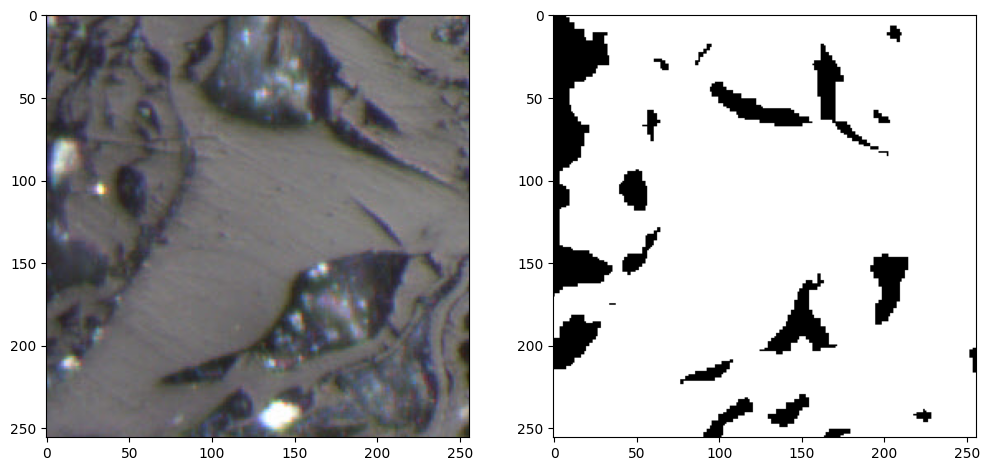

In [12]:
#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (256, 256, 3)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (256, 256)), cmap='gray')
plt.show()


In [13]:


#FOCAL LOSS AND DICE METRIC
#Focal loss helps focus more on tough to segment classes.
from focal_loss import BinaryFocalLoss


In [14]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
num_labels = 1  #Binary
input_shape = (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)
batch_size = 1

In [15]:
from tensorflow.keras.optimizers import Adam
#___________________________________________
'''
Attention Residual Unet
'''
att_res_unet_model = Attention_ResUNet(input_shape)

att_res_unet_model.compile(optimizer=Adam(learning_rate=1e-2), loss=BinaryFocalLoss(gamma=2), 
              metrics=['accuracy', jacard_coef])


# att_res_unet_model.compile(optimizer=Adam(lr = 1e-3), loss='binary_crossentropy', 
#               metrics=['accuracy', jacard_coef])

# print(att_res_unet_model.summary())


2024-06-20 01:20:02.911761: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint



# Load weights from epoch 2
att_res_unet_model.load_weights('/data1/sprasad/attntnadvUnet/model_weights/model_weights_epoch_50.weights.h5')


# Define the checkpoint callback to save weights from epoch 2 onwards
checkpoint_callback = ModelCheckpoint(
    filepath='model_weights/model_weights_epoch_{epoch:02d}.weights.h5',  # Path to save the model weights
    save_weights_only=True,                                               # Save only the model weights
    save_freq='epoch',                                                    # Save at the end of each epoch
    verbose=1,                                                            # Verbosity level                                                            # Save every epoch
                                                       # Start from epoch 2
)

# Train the model starting from epoch 2
att_res_unet_history = att_res_unet_model.fit(
    X_train, y_train,
    verbose=1,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    shuffle=False,
    epochs=100,
    callbacks=[checkpoint_callback],                                       # Include the callback here
    initial_epoch=50                                                       # Start training from epoch 33
)

/home/sprasad/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 354 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 51/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8214 - jacard_coef: 0.1767 - loss: 0.1067
Epoch 51: saving model to model_weights/model_weights_epoch_51.weights.h5
121/121 ━━━━━━━━━━━━━━━━━━━━ 360s 3s/step - accuracy: 0.8217 - jacard_coef: 0.1769 - loss: 0.1066 - val_accuracy: 0.6727 - val_jacard_coef: 0.1895 - val_loss: 0.1576
Epoch 52/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8545 - jacard_coef: 0.1952 - loss: 0.1019
Epoch 52: saving model to model_weights/model_weights_epoch_52.weights.h5
121/121 ━━━━━━━━━━━━━━━━━━━━ 324s 3s/step - accuracy: 0.8547 - jacard_coef: 0.1954 - loss: 0.1018 - val_accuracy: 0.6716 - val_jacard_coef: 0.1690 - val_loss: 0.1502
Epoch 53/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8911 - jacard_coef: 0.2194 - loss: 0.0869
Epoch 53: saving model to model_weights/model_weights_epoch_53.weights.h5
121/121 ━━━━━━━━━━━━━━━━━━━━ 311s 3s/step - accuracy: 0.8910 - jacard_coef: 0.2194 - loss: 0.0869 - val_accuracy: 0.812

In [ ]:
att_res_unet_model = Attention_ResUNet(input_shape)
model = att_res_unet_model

model_path = "/data1/sprasad/attntnadvUnet/model_weights/model_weights_epoch_50.weights.h5"
model.load_weights(model_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step


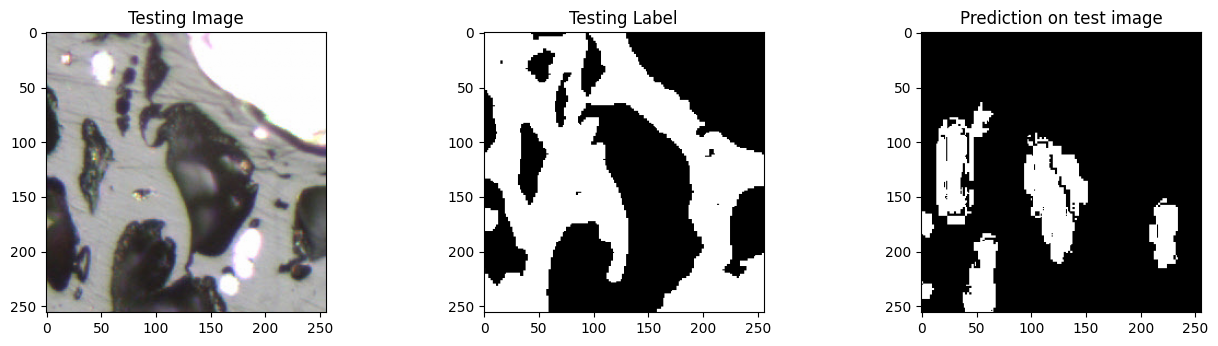

Mean IoU = 0.3309626


In [ ]:



import random
test_img_number = random.randint(0, X_test.shape[0]-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()


#IoU for a single image
from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(ground_truth[:,:,0], prediction)
print("Mean IoU =", IOU_keras.result().numpy())

In [ ]:
prediction.shape

(256, 256)